# PCA  on Order Features

In [1]:
import yaml,logging,numpy,pandas
from optparse import OptionParser
from feature import languages,Feature
from matplotlib import pyplot as plt
%matplotlib inline
features = yaml.load(open('features.yml'))
logging.basicConfig(level=logging.ERROR)

In [2]:
order_features = pandas.read_csv('word-order-features.csv')
order_features.describe()

,representation
count,56.000000
mean,568.821429
std,511.034427
min,5.000000
25%,66.000000
50%,446.000000
75%,1144.750000
max,1519.000000


Meaning there are 56 word-order related features according to WALS. They cover 568 languages on average with very large variance. We can crop the top half and see what gives.

In [3]:
# get the order features corresponding to quantile q
def qfeatures(q):
    hingh = order_features['representation'].quantile(q)
    return order_features[order_features['representation'] >= hingh]['id'].values
    
# get the submatrix corresponding to a quantile
def qlangs(q):
    cols = [c for c in languages.columns if c.split(" ")[0] in qfeatures(q)]
    qlangs = languages[cols]
    qlangs = qlangs.replace(to_replace=".+",regex=True,value=1)
    qlangs = qlangs.replace(to_replace='',value=0)
    qlangs['features_count'] = qlangs.apply(lambda x: sum(x), axis=1)
    return qlangs[qlangs['features_count'] == len(cols)]

for q in [0.7,0.8,0.9]:
    print("Number of languages that Share the top",q, "of order features:",len(qlangs(q)))

Number of languages that Share the top 0.7 of order features: 421
Number of languages that Share the top 0.8 of order features: 780
Number of languages that Share the top 0.9 of order features: 1016


sanity check:

In [5]:
qlangs09 = qlangs(0.9)
qlangs09

,"81A Order of Subject, Object and Verb",82A Order of Subject and Verb,83A Order of Object and Verb,87A Order of Adjective and Noun,143F Postverbal Negative Morphemes,143E Preverbal Negative Morphemes,143A Order of Negative Morpheme and Verb,143G Minor morphological means of signaling negation,features_count
0,1,1,1,1,1,1,1,1,8
7,1,1,1,1,1,1,1,1,8
8,1,1,1,1,1,1,1,1,8
10,1,1,1,1,1,1,1,1,8
12,1,1,1,1,1,1,1,1,8
13,1,1,1,1,1,1,1,1,8
16,1,1,1,1,1,1,1,1,8
17,1,1,1,1,1,1,1,1,8
20,1,1,1,1,1,1,1,1,8
23,1,1,1,1,1,1,1,1,8


In [10]:
languages.iloc[qlangs09.index][numpy.concatenate((['wals_code','Name','genus','family','macroarea'],
                                                  qlangs09.columns[:-1]),axis=0)].to_csv('raw-order-features-full.csv')

In [10]:
mat09 = numpy.zeros((0,len(qlangs09)))
numfeats = 0
for i,(name,details) in enumerate(features.items()):
    if details['wals_id'] in order_features['id'].values:
        print(i,name+":",details['desc'])
        numfeats += 1
        feat =  Feature(name,details)
        mat09 = numpy.vstack((mat09,feat.get_languages(qlangs09.index)))
    else:
        print("\nskipped",i,name,"WALS id:",details['wals_id'],":",details['desc'],"\n")
print(numfeats)

0 issov: binarising 81A on the SOV value (1)
1 word_order2: binarizing 82A on existance of value (3)
2 isovs: binarising 81A on OVS (5)
3 noun_adj: binarizing 87A on NAdj (2)
4 isvos: binarising 81A on VOS (4)
5 isosv: binarising 81A on OSV (6)
6 word_order1: binarising the wals feature to 1 if there is some order, -1 if not (that the wals 7 for this feature)
7 adj_noun_adj: binarizing 87A on the case where both orders are found (3)
8 isvso: binarising 81A on VSO (3)
9 issv: binarising 82A  on the SV value (1)

skipped 10 number_of_cases WALS id: 49A : taking the wals number of the feature, which foughly corresponds to the actual number of cases. e.g 7 means 8 or 9 cases 

11 adj_noun: binarizing 87A on AdjN (1)
12 issvo: binarising 81A on the SVO value (2), meaning it returns 1 if the language is SVO, -1 otherwise
13 word_order3: binarizing 87A on existance of value (3)
14 isvs: binarising 82A  on the VS value (2)
14


In [28]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(mat09.T)
PCA(copy=True, iterated_power='auto', n_components=3, random_state=None, svd_solver='auto', tol=0.0, whiten=False)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_)
print(mat09.T.shape)
cov = numpy.cov(mat09)
print(cov.shape)

[ 0.3803038   0.21791611  0.16753354]
[ 2.6157897   1.49886147  1.15232215]
(1016, 14)
(14, 14)


Let's plot the languages on the top 2 eigenvectors

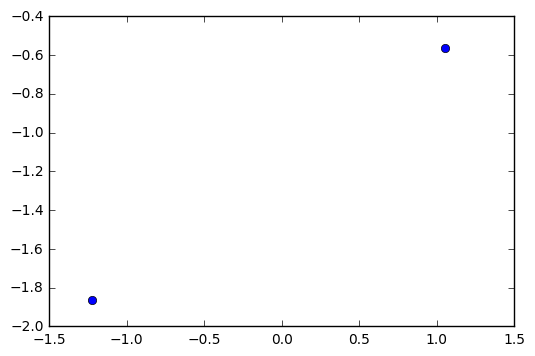

(1016, 2)

In [33]:
pca2 = PCA(n_components=2)
transformed = pca2.fit_transform(mat09.T)
plt.plot(transformed[1], transformed[0], 'o')
plt.show()
transformed.shape